# Proyecto de Predicción de Churn en Telecomunicaciones

 ## 1.Importaciones y Configuración General

In [336]:
#Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, RocCurveDisplay)


# Cargar datos

In [337]:
# Cargar data
data = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv') #Importar dataset desde el directorio del repositorio
data.head()  # 10 primera columnas

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [338]:
print(f"Dataset shape: {data.shape}") # Mostrar las dimensiones del dataset

Dataset shape: (7043, 21)


# Exploratory Data Analysis

In [339]:
data.info() # Mostrar información del dataset relevante del dataset y detectar valores nulos en sus columnas como los tipos de datos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [340]:
# Reemplazar valores nulos en 'TotalCharges' con 0
data.loc[:, 'TotalCharges'] = data['TotalCharges'].fillna(0) 

In [341]:
# Mapear churn a 0/1 y eliminar columnas irrelevantes
data['ChurnFlag'] = data['Churn'].map({'No':0,'Yes':1}) 
data['gender'] = data['gender'].map({'Female':0,'Male':1}) 
data['PhoneService'] = data['PhoneService'].map({'No':0,'Yes':1}) 
data['Dependents'] = data['Dependents'].map({'No':0,'Yes':1}) 
data['OnlineSecurity'] = data['OnlineSecurity'].map({'No':0,'Yes':1}) 
data['Partner'] = data['Partner'].map({'No':0,'Yes':1}) 
data['PaperlessBilling'] = data['PaperlessBilling'].map({'No':0,'Yes':1}) 
data['TechSupport'] = data['TechSupport'].map({'No':0,'Yes':1}) 
data['DeviceProtection'] = data['DeviceProtection'].map({'No':0,'Yes':1}) 
data['StreamingMovies'] = data['StreamingMovies'].map({'No':0,'Yes':1}) 
data['StreamingTV'] = data['StreamingTV'].map({'No':0,'Yes':1}) 
data.drop(columns=['customerID','Churn'], inplace=True)


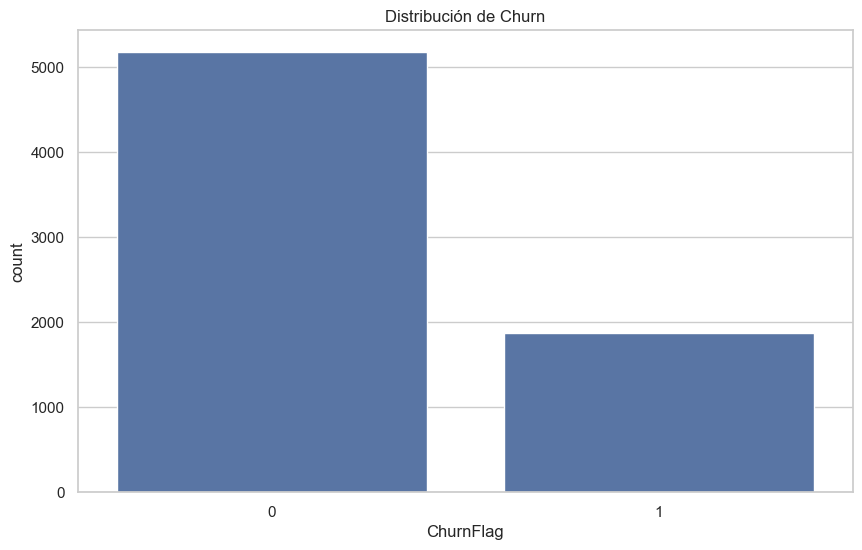

In [342]:
sns.countplot(x='ChurnFlag', data=data); # Visualizar la distribución de la variable objetivo 'Churn'
plt.title('Distribución de Churn'); # Título del gráfico

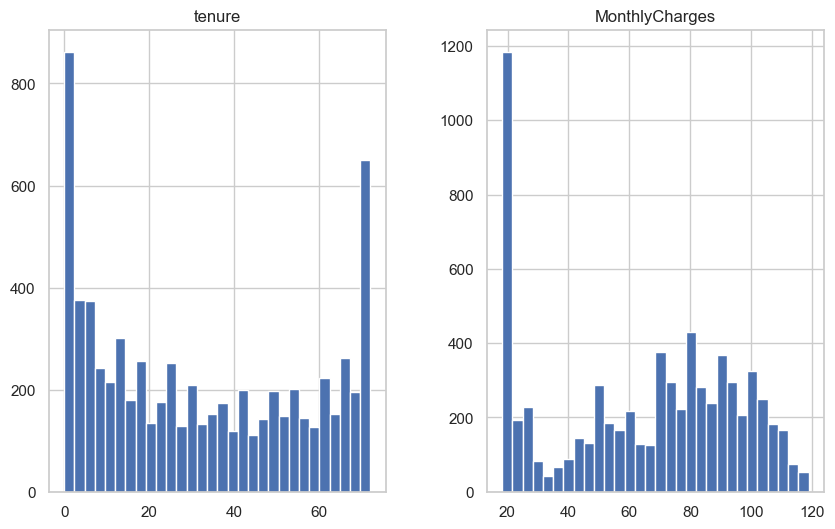

In [343]:
# Histogramas de variables numéricas
data[['tenure','MonthlyCharges','TotalCharges']].hist(bins=30);

In [344]:
# Estadísticas descriptivas de las variables numéricas
data.describe().T 

,count,mean,std,min,25%,50%,75%,max
gender,7043.0,0.504756,0.500013,0.00,0.0,1.00,1.00,1.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.0,0.00,1.00,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.0,0.00,1.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.0,1.00,1.00,1.00
OnlineSecurity,5517.0,0.365960,0.481742,0.00,0.0,0.00,1.00,1.00
DeviceProtection,5517.0,0.439007,0.496311,0.00,0.0,0.00,1.00,1.00
TechSupport,5517.0,0.370491,0.482980,0.00,0.0,0.00,1.00,1.00
StreamingTV,5517.0,0.490665,0.499958,0.00,0.0,0.00,1.00,1.00


In [345]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    5517 non-null   float64
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  5517 non-null   float64
 11  TechSupport       5517 non-null   float64
 12  StreamingTV       5517 non-null   float64
 13  StreamingMovies   5517 non-null   float64
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   object 


In [346]:
defined_numeric = [
    'ChurnFlag','gender','PhoneService','Dependents','OnlineSecurity',
    'Partner','PaperlessBilling','TechSupport','DeviceProtection',
    'StreamingMovies','StreamingTV','tenure','MonthlyCharges','TotalCharges']

In [347]:
# Filtrar DataFrame a estas columnas
data_num = data[defined_numeric]

In [348]:
data_num.info()  # Información del DataFrame filtrado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ChurnFlag         7043 non-null   int64  
 1   gender            7043 non-null   int64  
 2   PhoneService      7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   OnlineSecurity    5517 non-null   float64
 5   Partner           7043 non-null   int64  
 6   PaperlessBilling  7043 non-null   int64  
 7   TechSupport       5517 non-null   float64
 8   DeviceProtection  5517 non-null   float64
 9   StreamingMovies   5517 non-null   float64
 10  StreamingTV       5517 non-null   float64
 11  tenure            7043 non-null   int64  
 12  MonthlyCharges    7043 non-null   float64
 13  TotalCharges      7043 non-null   object 
dtypes: float64(6), int64(7), object(1)
memory usage: 770.5+ KB


In [ ]:
# Quitar espacios en los extremos
data_num['TotalCharges'] = data_num['TotalCharges'].str.strip()
# Eliminar todo lo que no sea dígito o punto
data_num['TotalCharges'] = data_num['TotalCharges'].str.replace(r'[^0-9.]', '', regex=True)
data_num['TotalCharges'] = pd.to_numeric(data_num['TotalCharges'], errors='raise')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\3575010536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['TotalCharges'] = data_num['TotalCharges'].str.strip()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\3575010536.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num['TotalCharges'] = data_num['TotalCharges'].str.replace(r'[^0-9.]', '', regex=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\3575010536.py:6: SettingWithCopyWarning: 
A value is try

Top 10 correlaciones: {'ChurnFlag': 1.0, 'tenure': 0.35222867011307885, 'OnlineSecurity': 0.2808163730932936, 'TechSupport': 0.2744218156579704, 'TotalCharges': 0.19948408356756397, 'MonthlyCharges': 0.19335642223784716, 'PaperlessBilling': 0.19182533166646884, 'DeviceProtection': 0.17712496477172537, 'Dependents': 0.16422140157972534, 'Partner': 0.1504475449591762}


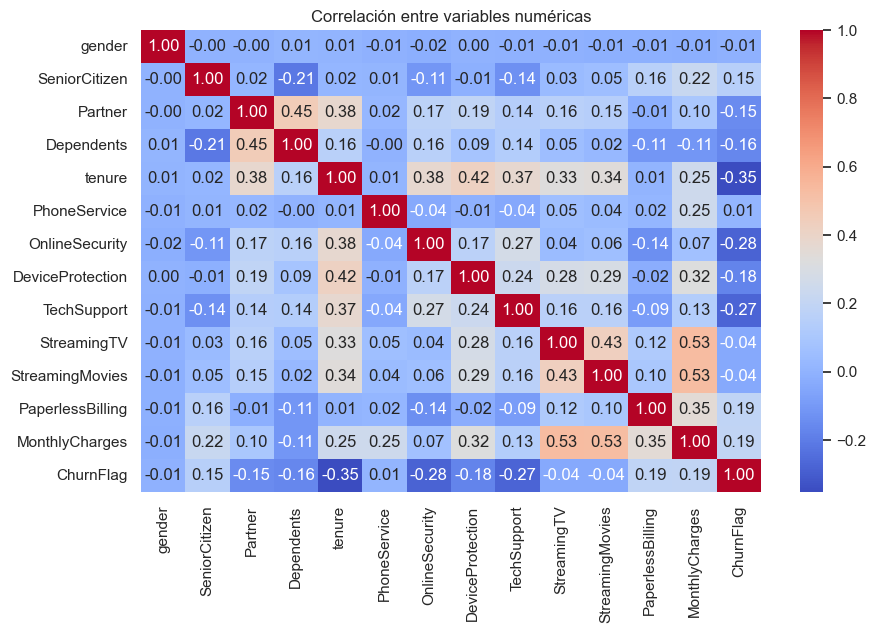

In [351]:
# Calcular correlaciones absolutas con la variable objetivo
corr_vals = data_num.corr()['ChurnFlag'].abs().sort_values(ascending=False)
print('Top 10 correlaciones:', corr_vals.head(10).to_dict())

sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.show()